GAN : Generative Adversarial Networks
그 중에서도 DCGAN : Depp Convolution GAN

진짜 지폐와 똑같은 위조지폐를 만들기위한 경찰과의 경합이 결국 더 정교한 위조지폐를 만든다.

가짜를 만들고 진짜와 비교하는 과정을 이용한다는 의미.

가짜를 만드는 파트 : Generator
진위를 가리는 파트 : Discriminator

----

Generator는 랜덤한 픽셀 값으로 채워진 이미지에서 시작해, 지속적인 Dsicriminator의 판별을 기반으로 픽셀 값을 업데이트에서 원하는 이미지를 만든다.

Generator에서는 optimizer혹은 compile 과정이 없다. 판별/학습이 Generator에서 일어나지 않기 때문이다.

일부 인자를 삭제하는 pooling 대신 padding이 추가된다. 입력과 출력의 크기를 똑같이 맞춰줘, 비교할 진짜 이미지와 같은 크기여야하기 때문.

padding = 'same' 설정을 통해서 자동으로 크기를 확장/0 채우기를 할 수 있다.

----

배치 정규화 : 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것

다음 층으로 입력될 값을 일정하게 재배치한다. 층의 개수가 늘어나도 안정적인 학습이 가능하게 된다. BatchNormalization()

ReLU(), tanh() 사용

In [7]:
# mnist를 GAN을 통해서 생성해줄 것이다.

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

np.random.seed(3)
tf.random.set_seed(3)

In [8]:
#생성자 모델을 만듭니다.
generator = Sequential()
# 128 = numbers of nodes, 7*7 = initial size of image
# UpSampling은 가로세로 2배를 해주기에, 최후에는 28*28이 될 것을 감안해서 초기 이미지 크기는 7*7로 한다.
# 작은 이미지들을 점점 늘려가면서 Convolution을 지난다.
# input_dim = 100 : 100 dimension의 random vector를 입력해야한다.
# LeakyReLU(0.2) = 0보다 작은 정의역에선 함수값이 0.2가 되도록 하라.
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 층 개수 증가해도 안정적인 학습이 가능하도록
generator.add(BatchNormalization())
# Conv2D 함수의 input으로 들어갈 수 있도록 입력값(input_shape)의 형태를 변환해준다. (행, 열, 색)
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))    # padding = 'same'이면 자동으로 0이 채워진다.
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))    # Discriminator로 값 넘길 때에는 활성화함수를 tanh로 한다.
generator.summary()    # Layer를 통해서 node의 shape을 파악하자

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)       

In [9]:
# 판별자 모델을 만듭니다.
# Convolution model을 그대로 가져와서 만든다.
# Discriminator는 학습을 하면 안된다. 여기서 얻은 가중치는 Generator로 넘긴다.
discriminator = Sequential()
# stride = 2 : 커널을 두 칸씩 움직인다. 가로, 세로의 길이가 줄어들고, 새로운 특징을 뽑게 된다. 또한 차원도 줄어든다.
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
# 진짜, 가짜 중 하나를 선택해야하므로 이에 적합한 sigmoid 함수를 선정한다.
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()
# 두가지 class(true or false) 구분에는 binary_crossentropy와 adam이 좋다.
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# discriminator의 학습 기능을 제거한다.
discriminator.trainable = False

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

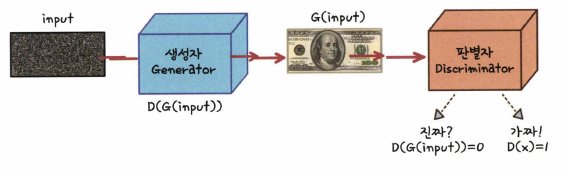

너무 유사해진 D(G(input))과 D(x)이 정확도가 0.5 이하가되면 학습을 종료시킨다.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
epoch:0  d_loss:0.3831  g_loss:1.8244
epoch:1  d_loss:0.6467  g_loss:1.7587
epoch:2  d_loss:0.5689  g_loss:1.0221
epoch:3  d_loss:0.6772  g_loss:0.8965
epoch:4  d_loss:0.6716  g_loss:1.4580
epoch:5  d_loss:0.7212  g_loss:1.5457
epoch:6  d_loss:0.4528  g_loss:2.2750
epoch:7  d_loss:0.5727  g_loss:1.9393
epoch:8  d_loss:0.4681  g_loss:1.8064
epoch:9  d_loss:0.5131  g_loss:1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


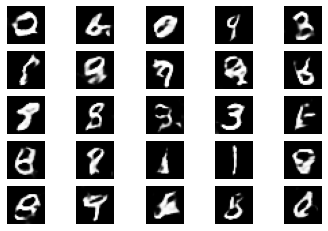

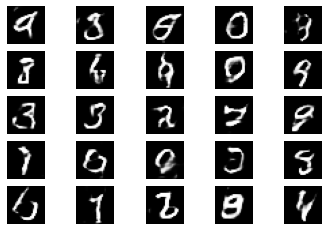

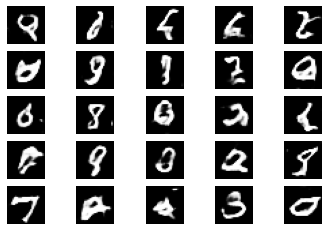

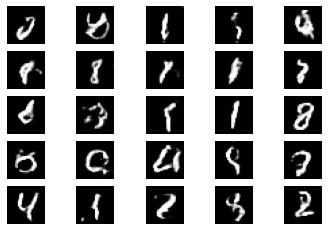

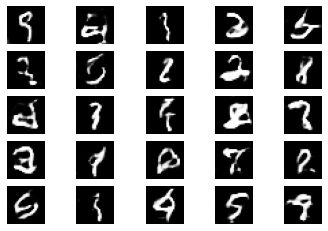

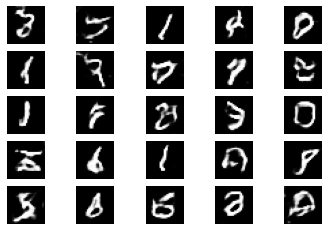

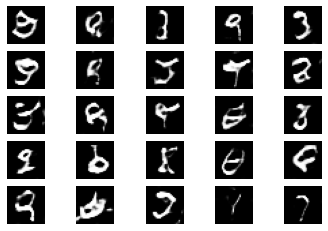

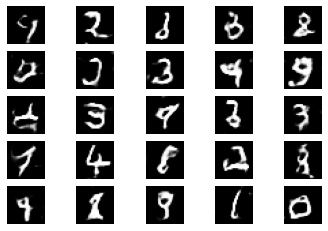

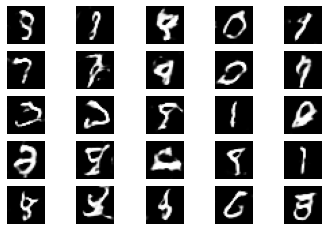

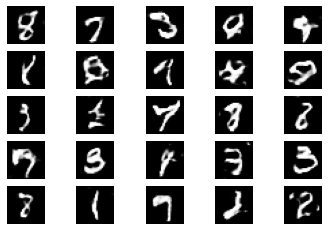

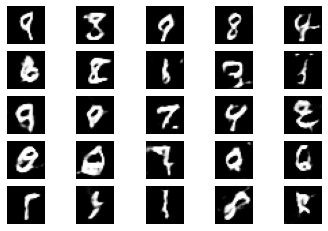

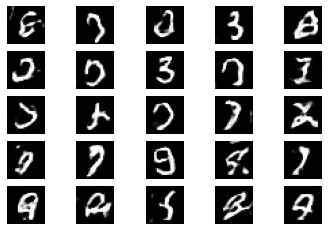

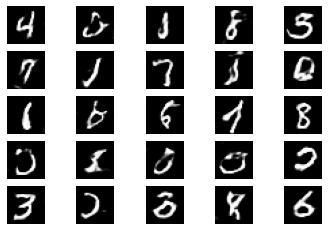

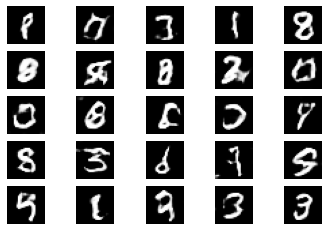

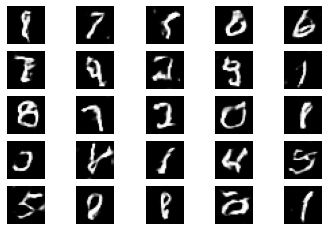

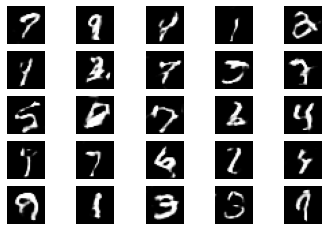

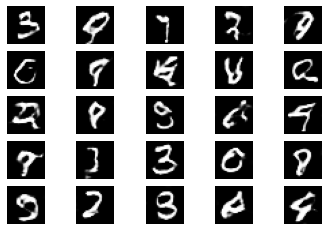

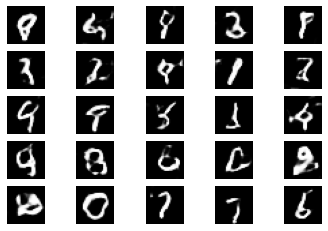

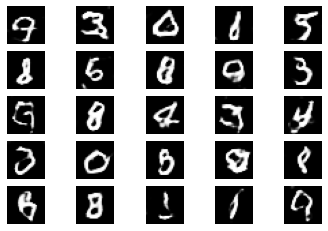

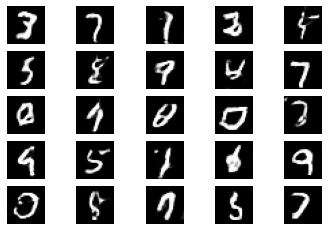

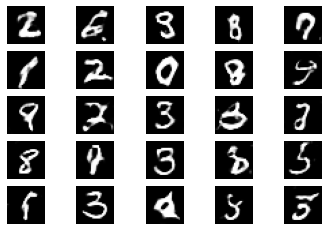

In [6]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))    # 입력값 : 랜덤한 100개의 벡터
dis_output = discriminator(generator(ginput))    # 출력값 
gan = Model(ginput, dis_output)   # 입출력 값으로 모델 생성
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data()  
  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 
  # 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5 
  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데,
  # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  # true에는 mnist 손글씨가 들어간다.
  # fake에는 랜덤 실수가 들어간다.
  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          # index를 랜덤하게 불러온다.
          # np.random.randint(a부터, b까지, 랜덤한 수를 가져올 회수 c)
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          # train_on_batch(입력값 x, 레이블 y)
          d_loss_real = discriminator.train_on_batch(imgs, true)    # 딱 한 번 판별과 학습을 실시, 모델 업데이트. 

          #가상 이미지를 판별자에 입력하는 부분입니다.
          # np.random.normal(a부터, b까지, c개를 랜덤으로 뽑아라) : 단 int가 아닌 float으로
          # (batch_size, 100) : batch_size만큼 100열을 뽑으라는 의미이다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)    # 딱 한 번 판별과 학습을 실시, 모델 업데이트.

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 가상 이미지와 실제 이미지의 평균값
          g_loss = gan.train_on_batch(noise, true) # GAN 모델에서 가상이미지를 투입, 딱 한 번 판별/학습 실시

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.